## Haytham Elghazel et Orhan Yazar

In [1]:
import numpy as np 
np.set_printoptions(threshold=10000,suppress=True) 
import pandas as pd
import warnings
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore')

# Partie 1

In [2]:
credit=pd.read_csv('./credit_scoring.csv',sep=";",header=0)

In [3]:
credit.head(3)

,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price,Status
0,9.0,1.0,60.0,30.0,0.0,1.0,1.0,73.0,129.0,0.0,0.0,800.0,846.0,1
1,17.0,1.0,60.0,58.0,1.0,1.0,0.0,48.0,131.0,0.0,0.0,1000.0,1658.0,1
2,10.0,0.0,36.0,46.0,0.0,2.0,1.0,90.0,200.0,3000.0,0.0,2000.0,2985.0,0


In [4]:
credit.shape

(4375, 14)

In [5]:
X=credit.iloc[:,:13].values
Y=credit.iloc[:,13].values

In [6]:
mp=100*np.sum(Y==0)/len(Y)
bp=100*np.sum(Y==1)/len(Y)

print("% Bon payeurs : {0:.2f} % Mauvais payeurs : {1:.2f}".format(bp,mp))

% Bon payeurs : 72.21 % Mauvais payeurs : 27.79


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier

In [8]:
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=0.5,random_state=1)

## Lancement des classifieurs

In [9]:
def classifieurs(Xtrain,Xtest,Ytrain,Ytest):
    DT=DecisionTreeClassifier(criterion='gini',random_state=1) #CART
    DT.fit(Xtrain,Ytrain)
    YDT=DT.predict(Xtest)

    print("Arbre de décision : Accuracy = {0:.2f}".format(accuracy_score(Ytest,YDT)*100))
    print(confusion_matrix(Ytest,YDT))

    print()

    KNN=KNeighborsClassifier(n_neighbors=5) #KNN
    KNN.fit(Xtrain,Ytrain)
    YKNN=KNN.predict(Xtest)

    print("KNN : Accuracy = {0:.2f}".format(accuracy_score(Ytest,YKNN)*100))
    print(confusion_matrix(Ytest,YKNN))

    print()

In [10]:
classifieurs(Xtrain,Xtest,Ytrain,Ytest)

Arbre de décision : Accuracy = 72.71
[[ 325  279]
 [ 318 1266]]

KNN : Accuracy = 72.49
[[ 189  415]
 [ 187 1397]]



### Normalisation des données

In [11]:
SS=StandardScaler()
SS.fit(Xtrain)
Xtrain_norm=SS.transform(Xtrain)
Xtest_norm=SS.transform(Xtest)

classifieurs(Xtrain_norm,Xtest_norm,Ytrain,Ytest)

Arbre de décision : Accuracy = 72.71
[[ 322  282]
 [ 315 1269]]

KNN : Accuracy = 75.27
[[ 286  318]
 [ 223 1361]]



### Ajout des variables

En utilisant le critere de Kaise, on prend les axes avec une variance superieur a 1 donc les 6 premieres.

In [12]:
pca=PCA(n_components=3).fit(Xtrain_norm)

Xtrain_pca=np.concatenate((Xtrain_norm,pca.transform(Xtrain_norm)),axis=1)
Xtest_pca=np.concatenate((Xtest_norm,pca.transform(Xtest_norm)),axis=1)

classifieurs(Xtrain_pca,Xtest_pca,Ytrain,Ytest)

Arbre de décision : Accuracy = 73.63
[[ 351  253]
 [ 324 1260]]

KNN : Accuracy = 75.64
[[ 283  321]
 [ 212 1372]]



# Selection des variables

['Income' 'Seniority' 'pca2' 'pca3' 'pca1' 'Price' 'Amount' 'Age' 'Assets'
 'Records' 'Expenses' 'Job' 'Time' 'Debt' 'Home' 'Marital']


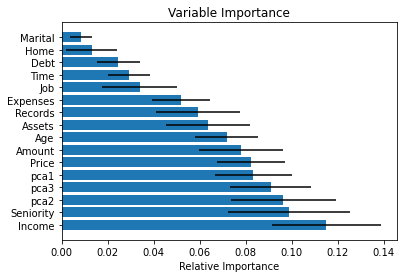

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(Xtrain_pca, Ytrain)
importances=clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
sorted_idx = np.argsort(importances)[::-1]

pca_cols = np.array(["pca1", "pca2", "pca3"], dtype='object')
features = np.concatenate((credit.columns.values[:13], pca_cols))

print(features[sorted_idx])
padding = np.arange(Xtrain_pca.size/len(Xtrain_pca)) + 0.5
plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

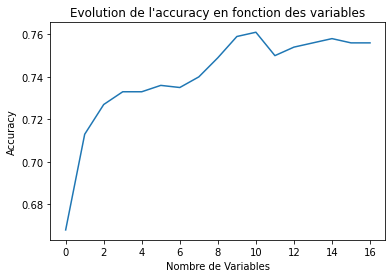

In [14]:
KNN=KNeighborsClassifier(n_neighbors=5)
scores=np.zeros(Xtrain_pca.shape[1]+1)

for f in np.arange(0, Xtrain_pca.shape[1]+1):
    X1_f = Xtrain_pca[:,sorted_idx[:f+1]]
    X2_f = Xtest_pca[:,sorted_idx[:f+1]]
    KNN.fit(X1_f, Ytrain)
    YKNN=KNN.predict(X2_f)
    scores[f]=np.round(accuracy_score(Ytest,YKNN),3)

plt.plot(scores)
plt.xlabel("Nombre de Variables")
plt.ylabel("Accuracy")
plt.title("Evolution de l'accuracy en fonction des variables")
plt.show()

La meilleur accuracy est atteinte avec 10 features.

In [15]:
X_train_selec = Xtrain_pca[:, sorted_idx[:10]]
X_test_selec = Xtest_pca[:, sorted_idx[:10]]

# Parametrage des classifiers

In [16]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

parameters = {
    'algorithm':('auto', 'ball_tree', 'kd_tree' 'brute'),
    'n_neighbors':[3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'leaf_size':[3, 4, 5, 6, 7, 8]
}
KNN=KNeighborsClassifier()
clf = GridSearchCV(KNN, parameters)
clf.fit(X_train_selec, Ytrain)

YSELEC = clf.predict(X_test_selec)
print("Gridsearch : Accuracy = {0:.2f}".format(accuracy_score(Ytest,YSELEC)*100))
print(confusion_matrix(Ytest,YSELEC))
print(clf.best_params_)

Gridsearch : Accuracy = 77.06
[[ 250  354]
 [ 148 1436]]
{'algorithm': 'auto', 'leaf_size': 3, 'n_neighbors': 15}


In [18]:
parameters = {
    'criterion':('gini', 'entropy'),
    'splitter':('best', 'random'),
    'max_features':('auto', 'sqrt', 'log2'),
    'max_depth':[3, 5, 7, 9]
}
DT = DecisionTreeClassifier()
clf = GridSearchCV(DT, parameters)
clf.fit(X_train_selec, Ytrain)

YSELEC = clf.predict(X_test_selec)
print("Gridsearch : Accuracy = {0:.2f}".format(accuracy_score(Ytest,YSELEC)*100))
print(confusion_matrix(Ytest,YSELEC))
print(clf.best_params_)

Gridsearch : Accuracy = 75.46
[[ 170  434]
 [ 103 1481]]
{'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'splitter': 'random'}


# Creation d'un pipeline

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class AddPCAFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, nbFeatures):
        self.nbFeatures = nbFeatures

    def fit(self, X, y):
        self.pca = PCA(n_components=self.nbFeatures).fit(X)
        return self

    def transform(self, X, y):
        return np.concatenate((X, self.pca.transform(X)),axis=1), y

In [20]:
a = AddPCAFeatures(nbFeatures=3)
a.fit(Xtrain, Ytrain)
b, c = a.transform(Xtest, Ytest)
print(b.shape)
print(c.shape)

(2188, 16)
(2188,)


In [45]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
#     ('add_pca', AddPCAFeatures(nbFeatures=3)),
#     ("knn", KNeighborsClassifier(algorithm='auto', leaf_size=3, n_neighbors=15))
])

pipe.fit(Xtrain, Ytrain)
pipe.transform(Xtrain, Ytrain)
# pipe.score(Xtest, Ytest)

TypeError: _transform() takes 2 positional arguments but 3 were given

# reste du prof

In [16]:
BAG=BaggingClassifier(n_estimators=100,random_state=1) #BAG
BAG.fit(Xtrain,Ytrain)
YBAG=BAG.predict(Xtest)
print("Bagging : Accuracy = {0:.2f}".format(accuracy_score(Ytest,YBAG)*100))
print(confusion_matrix(Ytest,YBAG))

Bagging : Accuracy = 78.56
[[ 332  272]
 [ 197 1387]]
